In [69]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics
from collections import Counter

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import os

%matplotlib inline

# File locations
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = '/Users/allisonmorgan/Documents/faculty_hiring/figures/'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [13]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)

In [81]:
deep_learning_keywords = ["ANN", "convolutional", "CNN", "neural", "recurrent", "RNN", "perceptron", "deep learning", 
                          "deep-learning", "recursive", "stochastic gradient descent", "SGD", "LSTM", "tensor",
                          "long short-term memory", "GAN", "generative adversarial network", "theano", "tensorflow",
                          "siamese network", "alexnet", "neuron", "neural network", "recurrent", "recursive", 
                          "attention", "keras", "word embedding", "deep belief net", "drop out", "word2vec", 
                          "sequence-to-sequence", "deep reinforcement learning", "deep neural network", "DNN", 
                          "boltzmann machine", "recursive auto-encoding", "recursive autoencoding", "hidden layer", 
                          "convnet", "rectified linear unit", "relu", "pooling", "gated recurrent unit", "gru",
                          "multilayer perceptron", "mlp", "autoencoder", "auto-encoder", "activation function", 
                          "affine layer", "backprop", "back-prop", "back prop", "bptt", "dropout", "epoch", 
                          "feedforward", "feed-forward", "neural machine translation", "nmt", "neural turing machine", 
                          "ntm", "global vectors for word representation", "glove", "actor-critic", "deepmind", 
                          "backtracking", "semi-supervised", "ladder network", "hyper parameter", 
                          "neural network-based", "zf net", "dense layer", "adadelta", "adagrad", "adam", 
                          "average-pooling", "batch normalization", "bidirectional rnn", "bidirectional recurrent", 
                          "caffe", "categorical cross-entropy loss", "channel", "dbn", "deep dream", 
                          "exploding gradient", "gradient clipping", "googlenet", "highway layer", "imagenet", 
                          "ilsvrc", "inception module", "max-pooling", "max pooling", "noise-contrastive estimation", 
                          "noise contrastive estimation", "restricted boltzmann", "rbn", "recursive neural network", 
                          "resnet", "rmsprop", "seq2seq","softmax", "vanishing gradient", "vgg", "neuro"]

**Note:** How will these results differ based on domain? Any other domains to consider?

Need to find all faculty members who have ever worked at an institution. Returns an array of faculty.

In [82]:
def faculty_at_institution(institution_name):
    people = []
    for f in asst_faculty:
        for job in f.faculty:
            if job['rank'] != "PostDoc" and job['place'] == institution_name:
                people.append(f)
                break
                
    return people 

## General trend in deep-learning research

In [55]:
def distribution():
    yearly_rate = Counter()
    for f in asst_faculty:
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                if any(pub['title'].lower().count(keyword) for keyword in deep_learning_keywords):
                    yearly_rate[pub['year']] += 1
                
    return yearly_rate 

dist = distribution()

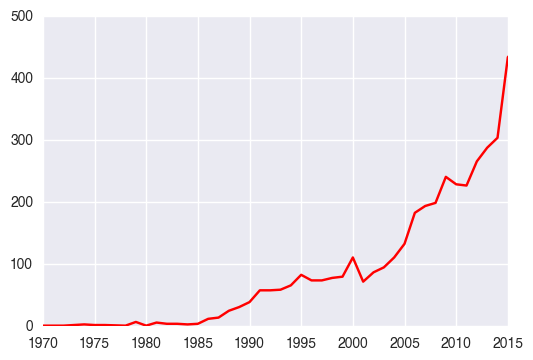

In [80]:
x = dict(dist).keys(); y = [];
for year, count in dict(dist).items():
    y.append(count)
    
plt.plot(x, y, color = 'r')
plt.xlim(1970, 2015)
plt.show()

## Walk-through an example university

Let's try this procedure on University of Colorado, Boulder

In [172]:
place = 'Brown University'

In [173]:
def get_hires_and_publications(place):
    hires_and_publications = []
    for f in faculty_at_institution(place):
        person = {"facultyName": f.facultyName}
    
        person["start"] = 2020; person["end"] = 0;
        for job in f.faculty:
            if job['place'] == place and not (job['start_year'] is None):
                person["start"] = min(job['start_year'], person["start"])
                person["end"] = max(job['end_year'], person["end"])
    
        if person["end"] == 0:
            person["end"] = 2011
        if person["start"] == 2020:
            continue
    
        relevant_pubs = []
        if f.__contains__("dblp_pubs"):
            for pub in f.dblp_pubs:
                relevant_venue = False
                if pub.has_key('venue') and not pub['venue'] is None:
                    if any(pub['venue'].lower().count(keyword) for keyword in deep_learning_keywords):
                        relevant_venue = True

                if any(pub['title'].lower().count(keyword) for keyword in deep_learning_keywords) or relevant_venue:
                    relevant_pubs.append(pub['year'])
    
        person["pubs"] = relevant_pubs
    
        hires_and_publications.append(person)
    
    return hires_and_publications

Let's plot the above data so we can better see when hires and publications occurred. 

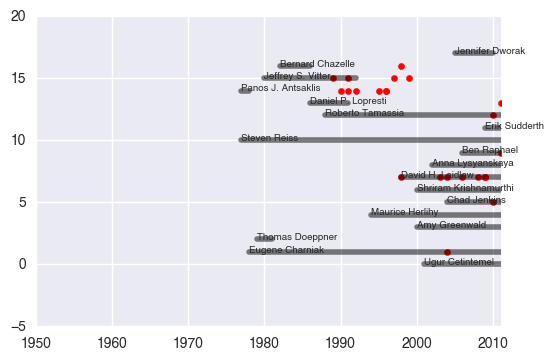

In [174]:
def plot_careers(place):
    i = 0
    for person in get_hires_and_publications(place):
        plt.plot([person["start"], person["end"]], [i, i], linewidth= 4, color = 'k', alpha = .5)
        plt.text(person["start"], i, person["facultyName"], fontsize=7)
    
        if len(person['pubs']) > 0:
            plt.scatter(person['pubs'], [i]*len(person['pubs']), s = 20, color = 'r')
        i += 1

    plt.xlim(1950, 2011)
    plt.show()

plot_careers(place)

Did the first deep-learning publication coincide with a faculty hiring event? Is the date of publication within two years of the author's hire? 

**Note:** Should we consider:
(1) window around hire data - the person the made the first deep learning contribution
(2) window around first relevant pub data

Keep in mind: do we often see a big gap in deep learning pubs between pre- and post-hire?

In [164]:
def date_of_first_pub(place):
    first_date = 2011;
    for i, person in enumerate(get_hires_and_publications(place)):
        if person["start"] == None and len(person['pubs']) == 0:
            continue
        
        for pub in person["pubs"]:
            if pub >= person["start"] and pub <= person["end"]:
                first_date = min(first_date, pub)
            
    return first_date

first_date = date_of_first_pub(place);
print "Date of university's first \"deep-learning\" publication: {0}".format(first_date)

Date of university's first "deep-learning" publication: 1972


Did the university hire someone who works on deep-learning within that date - 2 years (allowing for some start-up time)?

In [165]:
delta_t = 2;
def check_for_hire(time, delta_t, place):
    count_hiring_event = False;
    for i, person in enumerate(get_hires_and_publications(place)):
        if not person["start"] or len(person['pubs']) == 0:
            continue
    
        if any(pub <= first_date for pub in person['pubs']):
            if person["start"] >= (first_date - delta_t) and person["start"] <= first_date :
                count_hiring_event = True
    
    return count_hiring_event
            
print "\nWas a \"deep-learning\" researcher hired who might have led to the research area? {0}".format(check_for_hire(first_date, delta_t, place))


Was a "deep-learning" researcher hired who might have led to the research area? True


## For all universities

In [170]:
deep_learning_researcher_hired = 0
for place in inst.keys():
    if place == "UNKNOWN" or place == "All others":
        continue
        
    hires_and_publications = get_hires_and_publications(place)
    
    first_date = date_of_first_pub(place)
                
    if first_date == 2011:
        print "No \"deep-learning\" publications found for {0}!\n".format(place)
    else:
        print "Date of {0}'s first \"deep-learning\" publication: {1}".format(place, first_date)
    
        delta_t = 2; hiring_event = check_for_hire(first_date, delta_t, place);
        
        if hiring_event:
            deep_learning_researcher_hired += 1
        
        print "Was a \"deep-learning\" researcher hired within two-years of the first publication? {0}\n".format(hiring_event)

Date of Syracuse University's first "deep-learning" publication: 1995
Was a "deep-learning" researcher hired within two-years of the first publication? False

Date of Brown University's first "deep-learning" publication: 1989
Was a "deep-learning" researcher hired within two-years of the first publication? False

Date of Michigan Technological University's first "deep-learning" publication: 2002
Was a "deep-learning" researcher hired within two-years of the first publication? False

Date of Rice University's first "deep-learning" publication: 2003
Was a "deep-learning" researcher hired within two-years of the first publication? False

Date of University of Connecticut's first "deep-learning" publication: 1991
Was a "deep-learning" researcher hired within two-years of the first publication? False

Date of State University of New York, Albany's first "deep-learning" publication: 2009
Was a "deep-learning" researcher hired within two-years of the first publication? True

Date of Universit

In [171]:
deep_learning_researcher_hired/len(inst.keys())

0.3526570048309179